In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, SeparableConv1D, MaxPooling1D, Flatten, Dense, Dropout, Add
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def create_convolutional_block(x, filters, kernel_size=3):
    """
    Create a convolutional block with Conv1D, BatchNormalization, and ReLU activation
    """
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def create_inverted_residual_block(x, filters, kernel_size=3):
    """
    Create an inverted residual block as described in the paper:
    - Convolution
    - Separable Convolution
    - Batch Normalization
    - Activation
    - Convolution
    - Batch Normalization
    - Activation
    """
    # Store input for the skip connection
    skip = x

    # First convolution
    x = Conv1D(filters, 1, padding='same')(x)

    # Separable convolution (depth-wise + point-wise)
    x = SeparableConv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution
    x = Conv1D(filters, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add skip connection (residual connection)
    x = Add()([x, skip])

    return x

def create_output_block(x, num_classes=2):
    """
    Create output block with:
    - Max Pooling
    - Flatten
    - Dense Layer
    - Dropout
    - Final Dense Layer with Softmax
    """
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def build_phishing_detection_model(input_shape=(41, 1), num_filters=64, num_classes=2):
    """
    Build the complete phishing detection model with residual pipeline
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolutional block
    x = create_convolutional_block(inputs, num_filters)

    # Seven inverted residual blocks as mentioned in the paper
    for _ in range(7):
        x = create_inverted_residual_block(x, num_filters)

    # Final convolutional block after residual blocks
    x = create_convolutional_block(x, num_filters)

    # Output block
    outputs = create_output_block(x, num_classes)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def preprocess_url_features(url_features):
    """
    Preprocess URL features for the model
    - Reshape to add channel dimension
    """
    return np.reshape(url_features, (url_features.shape[0], url_features.shape[1], 1))

def predict_url_class(model, url_features, threshold=0.5):
    """
    Predict whether URLs are phishing (1) or benign (0)
    """
    # Get prediction probabilities
    predictions = model.predict(url_features)

    # Apply threshold (as mentioned in the paper)
    predicted_classes = (predictions[:, 1] >= threshold).astype(int)

    return predicted_classes

# Example usage
if __name__ == "__main__":
    # Build the model
    model = build_phishing_detection_model(input_shape=(41, 1))

    # Print model summary
    model.summary()

    # Load dataset
    df = pd.read_excel("feature_dataset.xlsx")


    df = df.drop(columns=["url"])

    X = df.drop(columns=["label"])
    y = df["label"]

    # Convert string labels to numbers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)  # "phishing" → 1, "clean" → 0

    print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

    # Normalize features (MLP performs better with scaled input)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=42)

    history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.35)

    # Predict on test set
    y_pred = predict_url_class(model, X_test, 0.5)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 41, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_128 (Conv1D)       │ (None, 41, 64)         │            256 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_128   │ (None, 41, 64)         │            256 │ conv1d_128[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_128            │ (None, 41, 64)         │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_129 (Conv1D)       │ (None, 41, 64)         │          4,160 │ activation_128[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv1d_56       │ (None, 41, 64)         │          4,352 │ conv1d_129[0][0]       │
│ (SeparableConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_129   │ (None, 41, 64)         │            256 │ separable_conv1d_56[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_129            │ (None, 41, 64)         │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_130 (Conv1D)       │ (None, 41, 64)         │          4,160 │ activation_129[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_130   │ (None, 41, 64)         │            256 │ conv1d_130[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_130            │ (None, 41, 64)         │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_56 (Add)              │ (None, 41, 64)         │              0 │ activation_130[0][0],  │
│                           │                        │                │ activation_128[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_131 (Conv1D)       │ (None, 41, 64)         │          4,160 │ add_56[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv1d_57       │ (None, 41, 64)         │          4,352 │ conv1d_131[0][0]       │
│ (SeparableConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 269,634 (1.03 MB)

 Trainable params: 267,586 (1.02 MB)

 Non-trainable params: 2,048 (8.00 KB)

{'clean': np.int64(0), 'phishing': np.int64(1)}
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 731ms/step - accuracy: 0.5620 - loss: 1.3717 - val_accuracy: 0.8200 - val_loss: 0.5815
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8356 - loss: 0.5887 - val_accuracy: 0.8200 - val_loss: 0.5918
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8684 - loss: 0.3273 - val_accuracy: 0.8000 - val_loss: 0.6281
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8334 - loss: 0.4530 - val_accuracy: 0.8000 - val_loss: 0.6048
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8738 - loss: 0.3433 - val_accuracy: 0.8000 - val_loss: 0.5614
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8653 - loss: 0.3053 - val_accuracy: 0.8200 - val_loss: 0.5268
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8988 - loss: 0.3234 - val_accuracy: 0.8200 - val_loss: 0.5344
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8356 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Matthews Correlation Coefficient (MCC): 0.0000


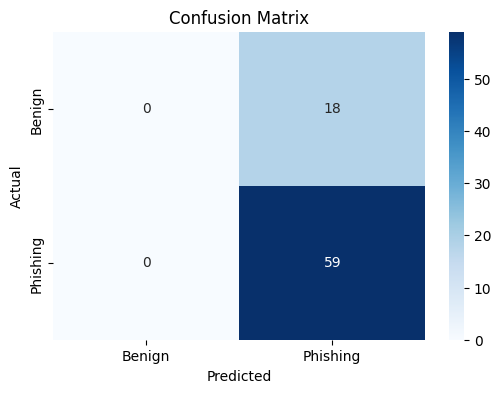

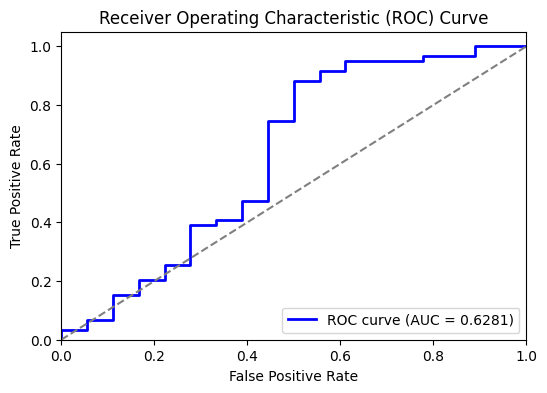

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute MCC
mcc = matthews_corrcoef(y_test, y_pred)

# Compute ROC Curve and AUC
y_prob = model.predict(X_test)[:, 1]  # Get probability scores for class 1 (phishing)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Print MCC
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Print Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Phishing"], yticklabels=["Benign", "Phishing"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


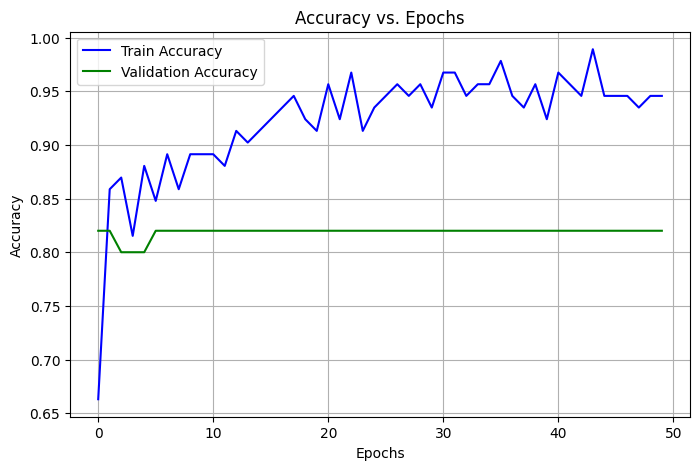

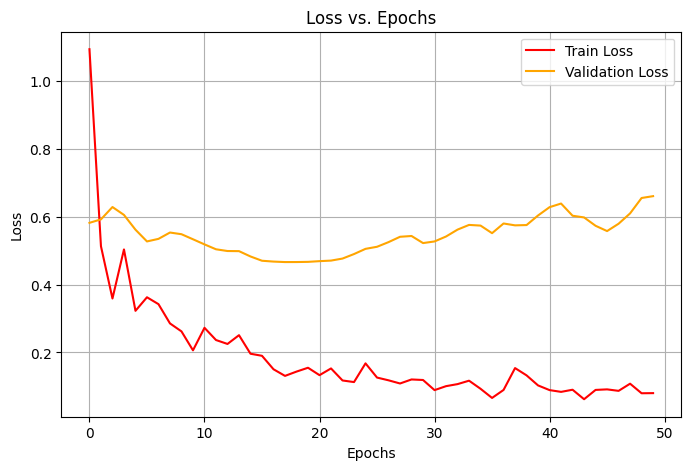

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy vs. epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot loss vs. epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid()
plt.show()
